In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

# Set random seed for reproducibility
np.random.seed(42)

# Helper function to plot confidence ellipses
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`
    
    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from the square root of the variance
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    
    # Calculating the standard deviation of y from the square root of the variance
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# ------------------------
# Problem 1: Covariance and Correlation Visualization
# ------------------------

def plot_correlation_examples():
    """Generate plots showing vectors with different correlations"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Different correlation values
    corr_values = [0.95, 0.5, 0, -0.8]
    titles = ["Strong positive correlation (≈ 0.95)", 
              "Moderate positive correlation (≈ 0.5)",
              "No correlation (≈ 0)", 
              "Strong negative correlation (≈ -0.8)"]
    
    # Generate data for each subplot
    for i, (ax, corr, title) in enumerate(zip(axes.flatten(), corr_values, titles)):
        mean = [0, 0]
        cov = [[1, corr], [corr, 1]]  # Covariance matrix
        
        # Generate random data with the specified correlation
        x, y = np.random.multivariate_normal(mean, cov, 100).T
        
        # Calculate the actual correlation
        actual_corr = np.corrcoef(x, y)[0, 1]
        
        # Plot data points
        ax.scatter(x, y, alpha=0.7)
        
        # Plot a line showing the correlation direction
        if corr != 0:
            # Calculate slope based on correlation
            slope = corr * np.std(y) / np.std(x)
            x_line = np.array([-2, 2])
            y_line = slope * x_line
            ax.plot(x_line, y_line, 'r-', alpha=0.7)
        
        # Add confidence ellipse
        confidence_ellipse(x, y, ax, n_std=2, edgecolor='red', linestyle='--')
        
        # Set labels and title
        ax.set_xlabel('x = r₁ - r̄₁')
        ax.set_ylabel('y = r₂ - r̄₂')
        ax.set_title(f"{title}\nActual correlation: {actual_corr:.2f}")
        ax.grid(True, alpha=0.3)
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        
        # Display the angle between vectors for non-zero correlations
        if corr != 0:
            angle = np.degrees(np.arccos(actual_corr))
            ax.text(0.05, 0.95, f"Angle between vectors: {angle:.1f}°", 
                    transform=ax.transAxes, fontsize=10, 
                    verticalalignment='top')
    
    plt.tight_layout()
    plt.savefig('correlation_examples.png', dpi=300)
    plt.close()

# ------------------------
# Problem 3: Bayes' Theorem Visualization
# ------------------------

def plot_posterior_equal_priors(mu_left=40, mu_right=60, sigma=10):
    """Plot posterior probabilities with equal priors"""
    # Parameters
    # mu_left = 40  # Mean firing rate for leftward motion
    # mu_right = 60  # Mean firing rate for rightward motion
    # sigma = 10     # Standard deviation of firing rates
    p_left = 0.5   # Prior probability of leftward motion
    p_right = 0.5  # Prior probability of rightward motion
    
    # Firing rate range
    r = np.linspace(10, 90, 1000)
    
    # Calculate likelihoods
    likelihood_left = np.exp(-0.5 * ((r - mu_left) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
    likelihood_right = np.exp(-0.5 * ((r - mu_right) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
    
    # Calculate evidence
    evidence = p_left * likelihood_left + p_right * likelihood_right
    
    # Calculate posteriors
    posterior_left = p_left * likelihood_left / evidence
    posterior_right = p_right * likelihood_right / evidence
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot likelihoods (scaled for visibility)
    scale_factor = 10
    ax.plot(r, scale_factor * likelihood_left, 'k:', linewidth=1.5, alpha=0.7, label='p(r|←) (scaled)')
    ax.plot(r, scale_factor * likelihood_right, 'k:', linewidth=2, alpha=0.7, label='p(r|→) (scaled)')
    
    # Plot posteriors
    ax.plot(r, posterior_left, 'k-', linewidth=2, label='p(←|r)')
    ax.plot(r, posterior_right, 'k--', linewidth=2, label='p(→|r)')
    
    # Plot the decision boundary
    decision_boundary = 0.5 * (mu_left + mu_right)
    ax.axvline(x=decision_boundary, color='k', linestyle='-', alpha=0.7, label='Decision boundary')
    
    # Shade regions with different hatching patterns
    ax.fill_between(r, 0, 1, where=(r < decision_boundary), color='lightgray', hatch='///', alpha=0.3)
    ax.fill_between(r, 0, 1, where=(r >= decision_boundary), color='lightgray', hatch='\\\\\\', alpha=0.3)
    
    # Add annotations
    ax.text(mu_left, 0.9, f'μ← = {mu_left}', horizontalalignment='center', fontweight='bold')
    ax.text(mu_right, 0.9, f'μ→ = {mu_right}', horizontalalignment='center', fontweight='bold')
    ax.text(decision_boundary + 2, 0.5, f'Boundary = {decision_boundary}', rotation=0, verticalalignment='center')
    
    # Add grid, labels, and legend
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Firing rate (r)')
    ax.set_ylabel('Probability')
    ax.set_title(f'Posterior Probabilities with Equal Priors (p(←) = p(→) = {p_left})')
    ax.set_ylim(0, 1)
    ax.legend(loc='center right')
    
    plt.tight_layout()
    plt.savefig('posterior_equal_priors.png', dpi=300)
    plt.show()
    plt.close()

def plot_posterior_unequal_priors(mu_left=40, mu_right=60, sigma=10):
    """Plot posterior probabilities with unequal priors"""
    
    # Firing rate range
    r = np.linspace(10, 90, 1000)
    
    # Prior combinations to compare
    prior_combinations = [
        # (0.5, 0.5, "Equal Priors: p(←) = p(→) = 0.5"),
        (0.8, 0.2, "Unequal Priors: p(←) = 0.8, p(→) = 0.2"),
        (0.2, 0.8, "Unequal Priors: p(←) = 0.2, p(→) = 0.8")
    ]
    
    # Create figure with subplots
    fig, axes = plt.subplots(len(prior_combinations), 1, figsize=(14, 10), sharex=True)

    # Process the unequal priors cases
    for i, (p_left, p_right, title) in enumerate(prior_combinations):
        # Calculate likelihoods
        likelihood_left = np.exp(-0.5 * ((r - mu_left) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
        likelihood_right = np.exp(-0.5 * ((r - mu_right) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
        
        # Calculate evidence
        evidence = p_left * likelihood_left + p_right * likelihood_right
        
        # Calculate posteriors
        posterior_left = p_left * likelihood_left / evidence
        posterior_right = p_right * likelihood_right / evidence
        
        # Find the decision boundary (posterior crossing point)
        # where posterior_left == posterior_right
        idx = np.argmin(np.abs(posterior_left - posterior_right))
        decision_boundary = r[idx]
        
        # Plot
        ax = axes[i]
        
        # Plot posteriors with different line styles
        ax.plot(r, posterior_left, 'k-', linewidth=2, label='p(←|r)')
        ax.plot(r, posterior_right, 'k--', linewidth=2, label='p(→|r)')
        
        # Plot fixed decision boundary
        fixed_boundary = 0.5 * (mu_left + mu_right)
        ax.axvline(x=fixed_boundary, color='k', linestyle=':', alpha=0.7, label='Fixed boundary')
        
        # Plot optimal decision boundary
        ax.axvline(x=decision_boundary, color='k', linestyle='-', alpha=1.0, label='Optimal boundary')
        
        # Shade regions with different hatching patterns
        ax.fill_between(r, 0, 1, where=(r < decision_boundary), color='lightgray', hatch='///', alpha=0.3)
        ax.fill_between(r, 0, 1, where=(r >= decision_boundary), color='lightgray', hatch='\\\\\\', alpha=0.3)
        
        # Add annotations
        ax.text(mu_left, 0.9, f'μ← = {mu_left}', horizontalalignment='center')
        ax.text(mu_right, 0.9, f'μ→ = {mu_right}', horizontalalignment='center')
        
        # Add grid, labels, and legend
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Firing rate (r)')
        ax.set_ylabel('Probability')
        ax.set_title(title)
        ax.set_ylim(0, 1)
        ax.legend(loc='center right')
        plt.savefig(f'posterior_unequal_priors_{i}.png', dpi=300)
    
    plt.tight_layout()
    plt.savefig('posterior_unequal_priors.png', dpi=300)
    plt.show()
    plt.close()

# ------------------------
# Problem 4: Linear Discriminant Analysis Visualization
# ------------------------

def plot_lda_decision_boundary():
    """Visualize LDA decision boundary for 2D case with uncorrelated neurons"""
    # Parameters for the two distributions
    mu_left = np.array([5, 8])    # Mean for leftward motion
    mu_right = np.array([8, 5])   # Mean for rightward motion
    sigma1 = 1.5                  # Standard deviation for neuron 1
    sigma2 = 1.0                  # Standard deviation for neuron 2
    
    # Create a grid of points
    x1 = np.linspace(0, 12, 100)
    x2 = np.linspace(0, 12, 100)
    X1, X2 = np.meshgrid(x1, x2)
    pos = np.dstack((X1, X2))
    
    # Diagonal covariance matrix
    cov_matrix = np.array([[sigma1**2, 0], [0, sigma2**2]])
    
    # Create multivariate normal distributions
    rv_left = multivariate_normal(mu_left, cov_matrix)
    rv_right = multivariate_normal(mu_right, cov_matrix)
    
    # Calculate probability densities
    Z_left = rv_left.pdf(pos)
    Z_right = rv_right.pdf(pos)
    
    # Calculate log-likelihood ratio
    log_likelihood_ratio = np.log(Z_left / Z_right)
    
    # Calculate parameters for the decision boundary
    a = (mu_left[0] - mu_right[0]) / sigma1**2
    b = (mu_left[1] - mu_right[1]) / sigma2**2
    c = -0.5 * ((mu_left[0]**2 - mu_right[0]**2) / sigma1**2 + 
                (mu_left[1]**2 - mu_right[1]**2) / sigma2**2)
    
    # Generate points for the decision boundary line
    # Using the equation: a*x + b*y + c = 0
    if b != 0:
        boundary_x = np.linspace(0, 12, 100)
        boundary_y = -(a * boundary_x + c) / b
    else:
        boundary_y = np.linspace(0, 12, 100)
        boundary_x = -c / a
    
    # Remove points outside the plot range
    valid_indices = (boundary_y >= 0) & (boundary_y <= 12)
    boundary_x = boundary_x[valid_indices]
    boundary_y = boundary_y[valid_indices]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot contours using grayscale instead of color
    contour_levels = np.linspace(-5, 5, 21)
    contour = ax.contourf(X1, X2, log_likelihood_ratio, contour_levels, cmap='Greys', alpha=0.6)
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label('Log-likelihood ratio')
    
    # Plot the decision boundary
    ax.plot(boundary_x, boundary_y, 'k-', linewidth=2, label='Decision boundary')
    
    # Plot the means with more distinct markers
    ax.scatter(mu_left[0], mu_left[1], c='k', s=120, marker='o', facecolors='none', 
               linewidth=2, label='Leftward (←)')
    ax.scatter(mu_right[0], mu_right[1], c='k', s=120, marker='s', facecolors='k', 
               linewidth=2, label='Rightward (→)')
    
    # Add confidence ellipses with more distinct line styles
    confidence_ellipse(mu_left[0] + np.random.normal(0, sigma1, 1000), 
                      mu_left[1] + np.random.normal(0, sigma2, 1000), 
                      ax, n_std=2, edgecolor='k', linestyle='-', linewidth=2, 
                      label='Left 95% region')
    
    confidence_ellipse(mu_right[0] + np.random.normal(0, sigma1, 1000), 
                      mu_right[1] + np.random.normal(0, sigma2, 1000), 
                      ax, n_std=2, edgecolor='k', linestyle='--', linewidth=2, 
                      label='Right 95% region')
    
    # Annotate the means more clearly
    ax.annotate('μ←', (mu_left[0], mu_left[1]), xytext=(5, 10),
                textcoords='offset points', fontsize=12, fontweight='bold')
    ax.annotate('μ→', (mu_right[0], mu_right[1]), xytext=(5, 10),
                textcoords='offset points', fontsize=12, fontweight='bold')
    
    # Add equation of the boundary
    equation = f"{a:.2f}r₁ + {b:.2f}r₂ + {c:.2f} = 0"
    ax.text(0.05, 0.95, f"Boundary equation:\n{equation}", transform=ax.transAxes,
            fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Add grid, labels, and legend
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Firing rate of neuron 1 (r₁)')
    ax.set_ylabel('Firing rate of neuron 2 (r₂)')
    ax.set_title('LDA Decision Boundary for Two Uncorrelated Neurons')
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 12)
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('lda_decision_boundary.png', dpi=300)
    plt.show()
    plt.close()


# Linear Discriminant Analysis (LDA) Decision Boundary Visualization

This figure illustrates the LDA decision boundary for a 2D case with two uncorrelated neurons responding to different motion directions. The grayscale contour plot represents the log-likelihood ratio between leftward and rightward motion.

**Parameters:**
- Mean firing rate for leftward motion (μ←): [5, 8]
- Mean firing rate for rightward motion (μ→): [8, 5]
- Standard deviation for neuron 1: σ₁ = 1.5
- Standard deviation for neuron 2: σ₂ = 1.0

The solid black line represents the decision boundary, which optimally separates the two motion categories. The 95% confidence regions for each motion direction are shown as ellipses. The decision boundary is defined by a linear equation based on the firing rates of both neurons, demonstrating how the brain could optimally decode motion direction from neural activity patterns.

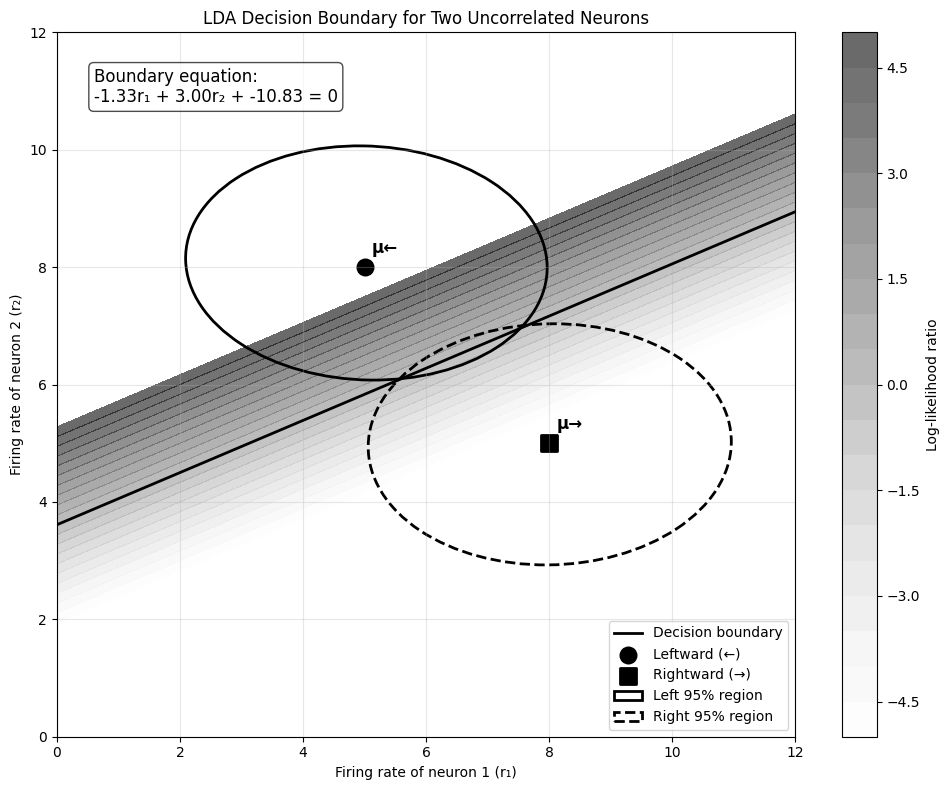

In [73]:
plot_lda_decision_boundary()

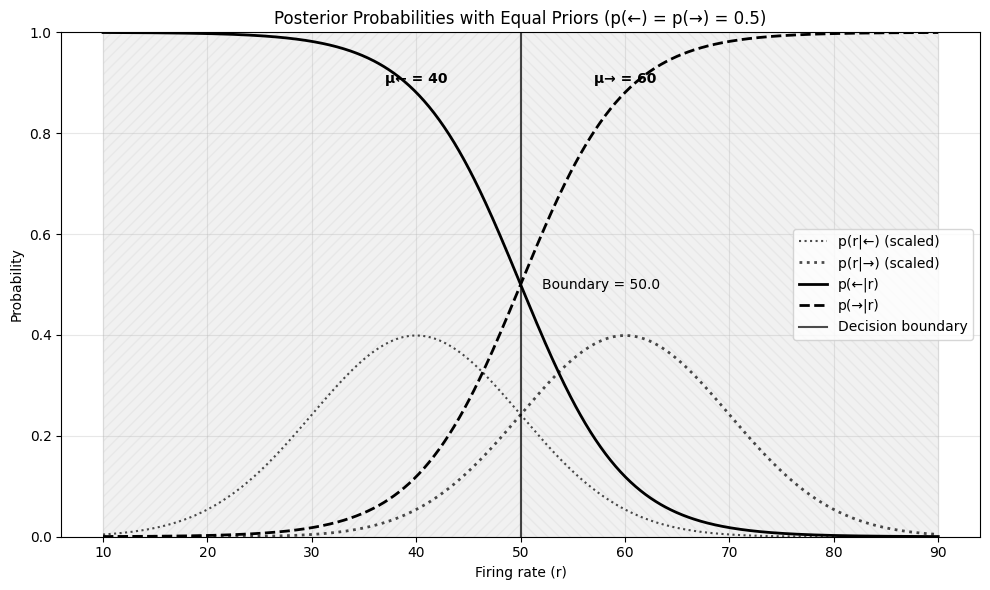

In [50]:
plot_posterior_equal_priors(mu_left=40, mu_right=60, sigma=10)

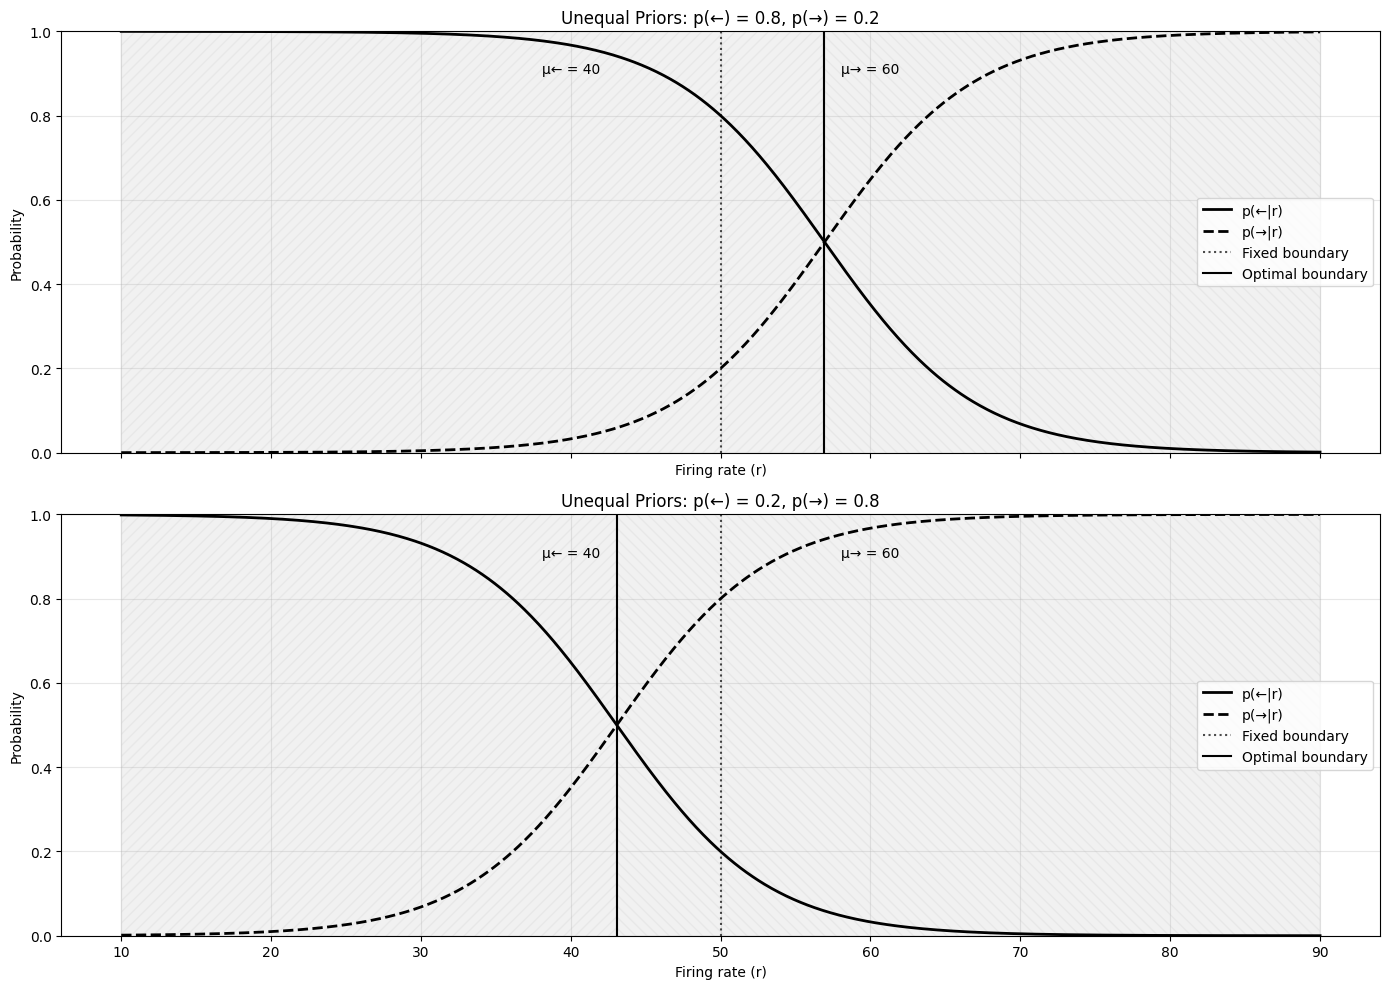

In [63]:
plot_posterior_unequal_priors()